In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt


In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

**DDB_03**

**Kaan Ak / Sumedh Bamane / Musaddaq Ehsan / Charles Frelet**

**Pre-processing of the user-book information**
Get a feel of the data. Describe characteristics of user rating data (e.g. verify the typical long-tail 
distribution of the ratings). Report your favorite stats that can help you guide the design of 
recommendation systems. Organize and clean books with all their metadata and user-item ratings.

**Implement a item-based and user-based collaborative filtering approach**


question 1 :**user-book matrices** this part is important also for the implementatation a matrix factorization collaborative approach

In [48]:
ratings = pd.read_csv("ratings.csv")
books = pd.read_csv("books.csv")


In [49]:
# Filter Users with at least 10 Ratings
user_rating_counts = ratings['user_id'].value_counts()
active_users = user_rating_counts[user_rating_counts >= 10].index
filtered_ratings = ratings[ratings['user_id'].isin(active_users)]

In [ ]:
user_book_matrix = filtered_ratings.pivot(index='user_id', columns='book_id', values='rating')


In [14]:
user_book_matrix = user_book_matrix.sub(user_book_matrix.mean(axis=1), axis=0).fillna(0)

In [20]:
sparse_matrix = csr_matrix(user_book_matrix.values)

**OUR KNN MODEL** (first one)

In [21]:
knn_model_user = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model_user.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [22]:
item_book_matrix = user_book_matrix.T  # Transpose to make books as rows
sparse_item_matrix = csr_matrix(item_book_matrix.values)
knn_model_item = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model_item.fit(sparse_item_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

In [62]:
def recommend_books(user_id, n_neighbors=5):
    if user_id not in user_book_matrix.index:
        return "User ID not found"

    user_idx = user_book_matrix.index.get_loc(user_id)
    distances, indices = knn_model_user.kneighbors([sparse_matrix[user_idx].toarray()[0]], n_neighbors=n_neighbors+1)

    recommendations = []
    for idx in indices.flatten()[1:]:  # Skip the first one (itself)
        similar_user_id = user_book_matrix.index[idx]
        top_books = ratings[ratings['user_id'] == similar_user_id].sort_values(by='rating', ascending=False)['book_id'].head(3).tolist()
        recommendations.extend(top_books)

    recommended_books = books[books['book_id'].isin(set(recommendations))][['book_id', 'title', 'authors']]
    
    return recommended_books

In [64]:
def find_similar_books(book_id, n_neighbors=5):
    if book_id not in item_book_matrix.index:
        return "Book ID not found"

    book_idx = item_book_matrix.index.get_loc(book_id)
    distances, indices = knn_model_item.kneighbors([sparse_item_matrix[book_idx].toarray()[0]], n_neighbors=n_neighbors+1)

    similar_books = []
    for idx in indices.flatten()[1:]:  # Skip first as it is the book itself
        similar_books.append(item_book_matrix.index[idx])

    return books[books['book_id'].isin(similar_books)][['book_id', 'title', 'authors']]

In [65]:
def visualize_recommendations(recommendations, title, color):
    plt.figure(figsize=(10, 6))
    recommendations = recommendations.reset_index(drop=True)

    plt.barh(recommendations['title'], range(len(recommendations), 0, -1), color=color)

    plt.xlabel("Ranking", fontsize=12)
    plt.ylabel("Book Titles", fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.gca().invert_yaxis()  # Ensure the best-ranked book is at the top
    plt.show()

THIS IS AN EXEMPLE, **FEEL FREE TO CHANGE THE USER/BOOK ID !**

In [73]:
user_id = 8
book_id = 253

user_recommendations = recommend_books(user_id=user_id)
similar_books = find_similar_books(book_id=book_id)

WE want that the vizualize the preferences of our system. So that you understand better


📚 **Top Recommended Books for User 8 (KNN-Based Recommendation):**
      book_id                                              title  \
12         13                                               1984   
42         43                                          Jane Eyre   
53         54  The Hitchhiker's Guide to the Galaxy (Hitchhik...   
75         76                              Sense and Sensibility   
93         94                      One Hundred Years of Solitude   
176       177                               Crime and Punishment   
412       413                               The Three Musketeers   
613       614                                          The Trial   
650       651                           The Phantom of the Opera   
871       872                                         The Plague   
958       959            A Portrait of the Artist as a Young Man   
2296     2297                                  Faust: First Part   
4347     4348                                 Th

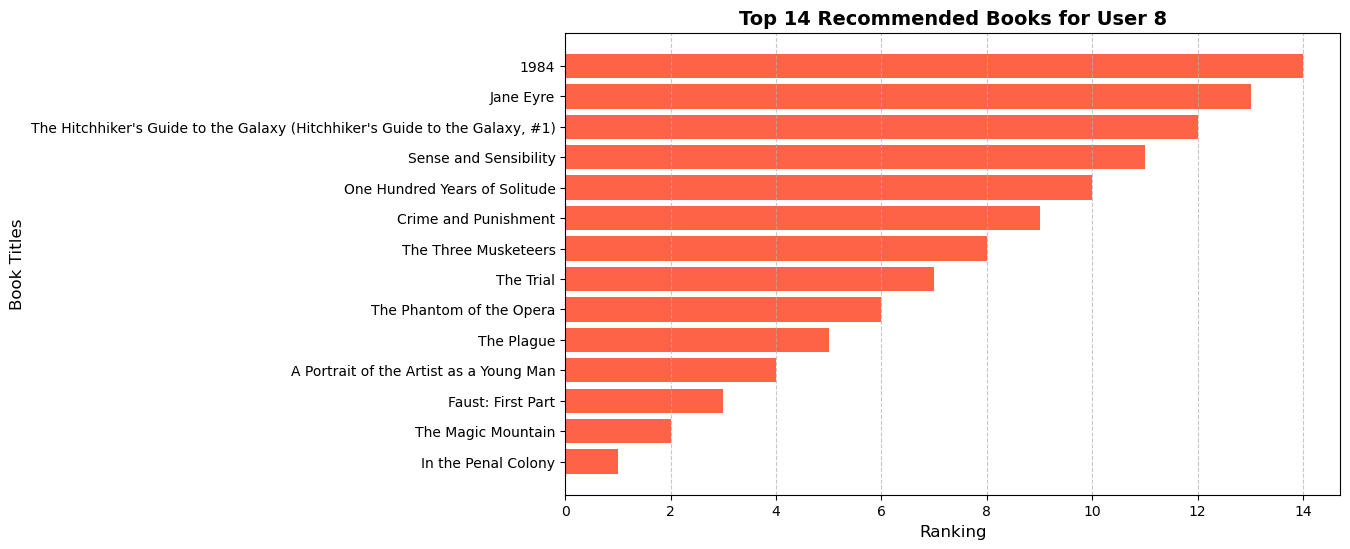


🔍 **Books Similar to 'The Scorch Trials (Maze Runner, #2)' (KNN-Based Similarity):**
     book_id                               title        authors
90        91   The Maze Runner (Maze Runner, #1)  James Dashner
104      105           Allegiant (Divergent, #3)  Veronica Roth
375      376    The Death Cure (Maze Runner, #3)  James Dashner
654      655               Crossed (Matched, #2)    Ally Condie
945      946  The Kill Order (Maze Runner, #0.5)  James Dashner


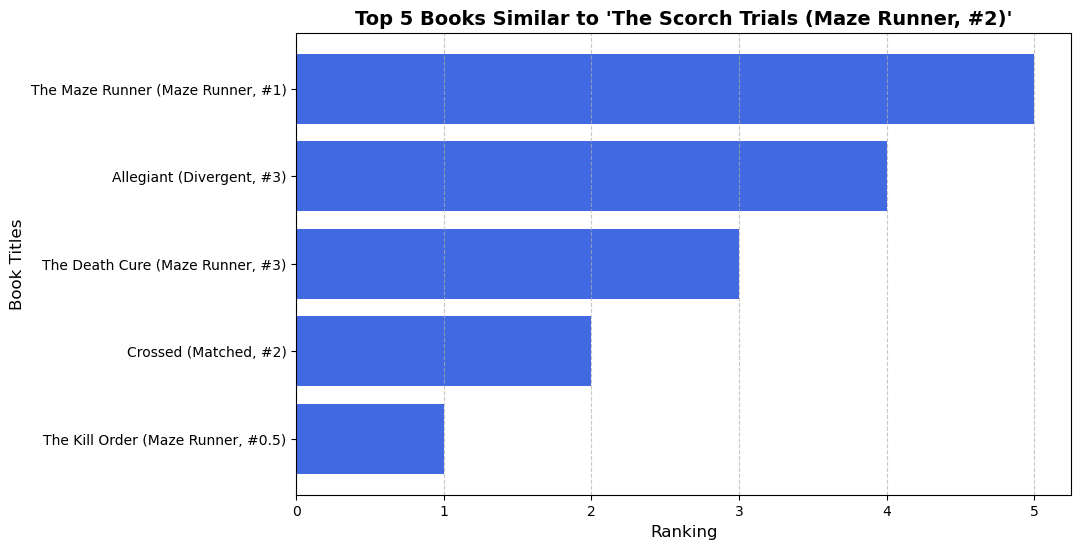

In [72]:
if isinstance(user_recommendations, str):
    print(user_recommendations)
else:
    print(f"\n📚 **Top Recommended Books for User {user_id} (KNN-Based Recommendation):**")
    print(user_recommendations)

    visualize_recommendations(user_recommendations,
                              f"Top {len(user_recommendations)} Recommended Books for User {user_id}",
                              color="tomato")

# Display Book-Based Recommendations
if isinstance(similar_books, str):
    print(similar_books)
else:
    book_title = books[books['book_id'] == book_id]['title'].values[0]
    print(f"\n🔍 **Books Similar to '{book_title}' (KNN-Based Similarity):**")
    print(similar_books)
    visualize_recommendations(similar_books,
                              f"Top {len(similar_books)} Books Similar to '{book_title}'",
                              color="royalblue")


**QUESTION 2** :. How do you deal with missing values in the user-book matrix? Describe under what situations 
this approach is likely to fail. What happens with lesser known books? Does this method scale 
well? 

In a real-world recommender system, missing values in the user-book matrix occur because most users have only rated a small subset of books, making the matrix extremely sparse.

**THIS IS HOW WE HANDLE MISSING VALUES**


Filling Missing Ratings with Zero **(fillna(0))**:

This assumes that missing ratings mean implicit disinterest.
Used when working with sparse matrices for KNN, as many algorithms require numerical inputs.

**Mean-Centering (Normalization)** (sub(user_book_matrix.mean(axis=1), axis=0)):

Instead of assuming 0, we replace missing values with deviation from the user's mean rating.
Helps when working with distance-based methods like cosine similarity.




Instead of directly filling missing values, we can infer them by **factorizing the matrix** (SVD, ALS)

Our main limitation is **sparsity** issues 

**The user-book matrix is sparse because most users have rated only a few books**

KNN struggles with sparse data since it relies on distance computation, which works poorly when most values are missing.

Therefore we used **Using Matrix Factorization (SVD)** . This solution was found by GPT (Python )

**WE MIGHT FACE SCALABILITY ISSUES**

Because the KNN method KNN stores all data in memory and performs brute-force similarity searches, wich is not scalable

I look on the web, and scalability is a big issue for KNN. 

it's better to use Neural Collaborative Filtering as we will do in the next exercise ( **matrix factorization collaborative filtering approach**)

***IMPLENTATION of matrix factorization collaborative filtering approach** (part 2)

In [31]:
from sklearn.decomposition import TruncatedSVD

In [32]:
# Perform SVD with a Reduced Number of Components (Top k Features)
k = 50  # Choosing a lower dimension for approximation
svd = TruncatedSVD(n_components=k)
U = svd.fit_transform(sparse_matrix)  # User feature matrix
Sigma = np.diag(svd.singular_values_)  # Diagonal matrix of weights
Vt = svd.components_  # Book feature matrix

In [33]:
R_approx = np.dot(np.dot(U, Sigma), Vt)

**OUR KNN MODEL** (second one)

In [35]:
def recommend_books_svd(user_id, top_n=5):
    if user_id not in user_book_matrix.index:
        return "User ID not found"
    
    user_idx = user_book_matrix.index.get_loc(user_id)
    predicted_ratings = R_approx[user_idx]
    book_indices = np.argsort(predicted_ratings)[::-1][:top_n]
    
    recommended_books = books[books['book_id'].isin(user_book_matrix.columns[book_indices])][['book_id', 'title', 'authors']]
    return recommended_books

**EXEMPLE**, once again feel free to change the value (user), it work !!!

In [88]:

user_id = 6
user_recommendations_svd = recommend_books_svd(user_id=user_id)



In [89]:
def visualize_recommendations(recommendations, title, color):
    plt.figure(figsize=(10, 6))
    recommendations = recommendations.reset_index(drop=True)
    recommendations['rank'] = range(1, len(recommendations) + 1)
    colors = sns.color_palette("viridis", len(recommendations))
    plt.barh(recommendations['title'], recommendations['rank'], color=colors, edgecolor='black')
    for i, (title, rank) in enumerate(zip(recommendations['title'], recommendations['rank'])):
        plt.text(rank - 0.5, i, f" #{rank}", va='center', ha='right', fontsize=12, color='white', fontweight='bold')

    plt.xlabel("Ranking", fontsize=14, fontweight="bold")
    plt.ylabel("Book Titles", fontsize=14, fontweight="bold")
    plt.title(title, fontsize=16, fontweight='bold', color=color)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.gca().invert_yaxis()  # Ensure the best-ranked book is at the top
    plt.show()



📚 **Top Recommended Books for User 6 (SVD-Based Prediction):**
     book_id                      title  \
7          8     The Catcher in the Rye   
10        11            The Kite Runner   
14        15  The Diary of a Young Girl   
44        45                 Life of Pi   
100      101     Me Talk Pretty One Day   

                                               authors  
7                                        J.D. Salinger  
10                                     Khaled Hosseini  
14   Anne Frank, Eleanor Roosevelt, B.M. Mooyaart-D...  
44                                         Yann Martel  
100                                      David Sedaris  


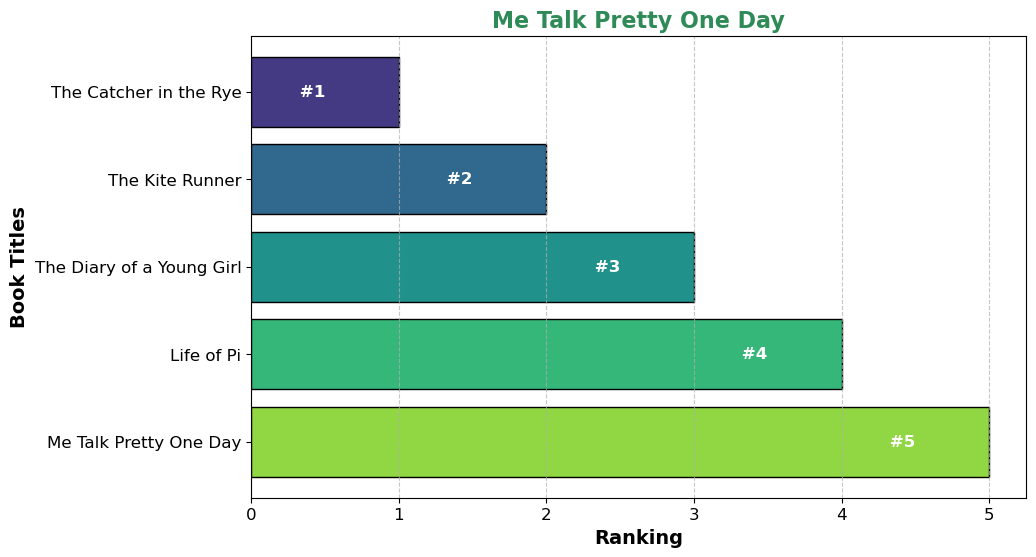

In [90]:
if isinstance(user_recommendations_svd, str):
    print(user_recommendations_svd)
else:
    print(f"\n📚 **Top Recommended Books for User {user_id} (SVD-Based Prediction):**")
    print(user_recommendations_svd)

    # Improved Visualization for SVD-Based Recommendations
    visualize_recommendations(
        user_recommendations_svd,
        f"Top {len(user_recommendations_svd)} Recommended Books for User {user_id} (SVD)",
        color="seagreen"
    )


QUESTION 2 : updated recommendation system function to ensure that it excludes books already rated by the user

we will strictly follow the matrix multiplication approach for recommendations

just some parameters

In [91]:
user_rating_counts = ratings['user_id'].value_counts()
active_users = user_rating_counts[user_rating_counts >= 10].index
filtered_ratings = ratings[ratings['user_id'].isin(active_users)]
user_book_matrix = filtered_ratings.pivot(index='user_id', columns='book_id', values='rating')
user_book_matrix = user_book_matrix.fillna(0)
sparse_matrix = csr_matrix(user_book_matrix.values)
k = 50  
svd = TruncatedSVD(n_components=k)
U = svd.fit_transform(sparse_matrix) 
Sigma = np.diag(svd.singular_values_) 
Vt = svd.components_  

# Compute the Predicted Ratings Matrix using Matrix Multiplication
R_approx = np.dot(U, np.dot(Sigma, Vt))

**OUR KNN MODEL** (Third one)

In [92]:
def recommend_books_svd(user_id, top_n=5):
    if user_id not in user_book_matrix.index:
        return "User ID not found"
    
    user_idx = user_book_matrix.index.get_loc(user_id)
    predicted_ratings = R_approx[user_idx]  # Directly from SVD approximation
    
    # Find books the user has NOT already rated
    rated_books = user_book_matrix.loc[user_id][user_book_matrix.loc[user_id] > 0].index
    
    # Sort books by predicted rating in descending order
    sorted_books = np.argsort(predicted_ratings)[::-1]  # Get indices sorted by predicted rating
    
    # Select top N **unseen** books
    recommended_books = [book for book in user_book_matrix.columns[sorted_books] if book not in rated_books][:top_n]
    
    return books[books['book_id'].isin(recommended_books)][['book_id', 'title', 'authors']]

EXEMPLE : **feel free to modify the user_id**

In [44]:
import matplotlib.pyplot as plt

Top Recommended Books for User 7 (SVD Matrix Multiplication):
    book_id                                              title  \
3         4                              To Kill a Mockingbird   
6         7                                         The Hobbit   
13       14                                        Animal Farm   
53       54  The Hitchhiker's Guide to the Galaxy (Hitchhik...   
69       70                    Ender's Game (Ender's Saga, #1)   

             authors  
3         Harper Lee  
6     J.R.R. Tolkien  
13     George Orwell  
53     Douglas Adams  
69  Orson Scott Card  


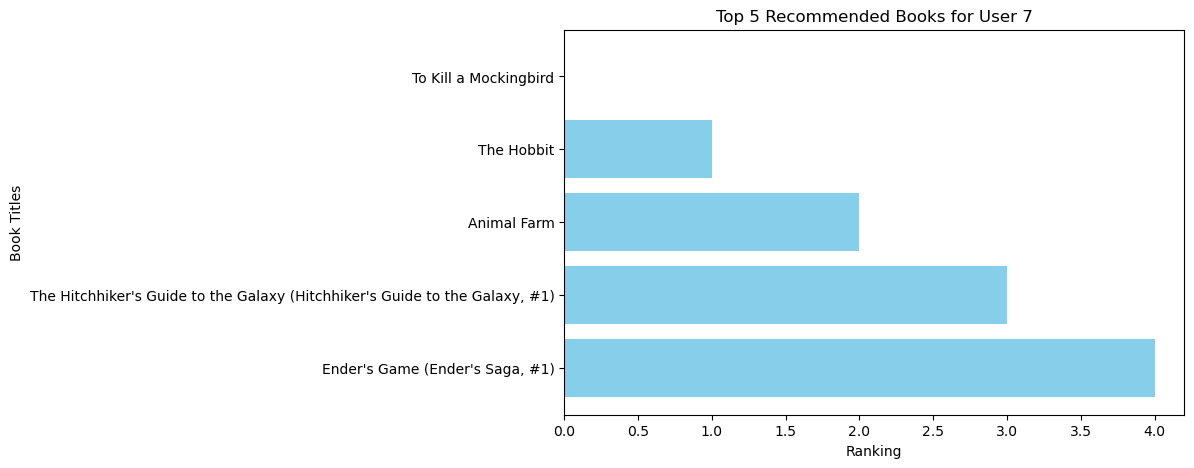

In [94]:
user_id = 7
user_recommendations_svd = recommend_books_svd(user_id=user_id)
if isinstance(user_recommendations_svd, str):
    print(user_recommendations_svd)
else:
    print(f"Top Recommended Books for User {user_id} (SVD Matrix Multiplication):")
    print(user_recommendations_svd)
    
    # Visualizing Recommendations
    plt.figure(figsize=(8, 5))
    plt.barh(user_recommendations_svd['title'], range(len(user_recommendations_svd)), color='skyblue')
    plt.xlabel("Ranking")
    plt.ylabel("Book Titles")
    plt.title(f"Top {len(user_recommendations_svd)} Recommended Books for User {user_id}")
    plt.gca().invert_yaxis()
    plt.show()


In [40]:
user_recommendations_svd = recommend_books_svd(user_id=4)

print("Recommended Books for User 2 (SVD Matrix Multiplication):")
print(user_recommendations_svd)


Recommended Books for User 2 (SVD Matrix Multiplication):
    book_id                                              title  \
0         1            The Hunger Games (The Hunger Games, #1)   
14       15                          The Diary of a Young Girl   
30       31                                           The Help   
36       37  The Lion, the Witch, and the Wardrobe (Chronic...   
42       43                                          Jane Eyre   

                                              authors  
0                                     Suzanne Collins  
14  Anne Frank, Eleanor Roosevelt, B.M. Mooyaart-D...  
30                                   Kathryn Stockett  
36                                         C.S. Lewis  
42                    Charlotte Brontë, Michael Mason  


**QUESTION 3** : Compare this approach to the item based one and describe in what situations this approach is 
likely to fail.

Both SVD-based matrix factorization and item-based collaborative filtering (CF) are popular recommendation techniques, but they have key differences in how they operate and their limitations.

One major limitation of SVD-based **matrix factorization** is its inability to handle new users and new books effectively. Since SVD relies on historical interactions, any new user with no prior ratings will have no latent factor representation, making it impossible to generate personalized recommendations.

This cold-start problem is a **critical weakness** in real-world recommendation systems, especially for dynamic environments where new users and items are frequently introduced.

The main **comparison** that we can make is that the matrix learns latent factors (hidden patterns) from user-book interactions. And KNN finds similar books based on past user ratings.

The matrix is more efficient for large datasets due to dimensionality reduction. And KKNN might be Slower for large datasets due to pairwise comparisons. 
Matrix scales well compare to Item-Based Collaborative Filtering (KNN). Even if KNN is flexible for real time updates

It depend on the needs 🤷

It was a pleasure to work on the basic tasks !!!